In [46]:
#Importing all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy
from nltk import FreqDist

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel, phrases
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import seaborn as sns
import os, re, operator, warnings
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now
%matplotlib inline

In [39]:
PROJ_ROOT = '/Users/dmitriykats/Documents/SpringBoard/Springboard/Capstone2/true_review/'

In [50]:
#import local python functions
import sys
src_dir = os.path.join(PROJ_ROOT, 'src')
sys.path.append(src_dir)

#import methods
from features.nlp_preprocess import freq_words

In [108]:
path = '/Users/dmitriykats/Documents/SpringBoard/Springboard/Capstone2/true_review/data/'

In [359]:
#we've already pre-processed the data so we can import it
df_scott = pd.read_csv(f'{path}/interim/sdl_data.csv', parse_dates=['date'])
df_scott = df_scott.drop(columns='Unnamed: 0')

In [360]:
df_scott.head()

,user_id,business_id,rev_stars,date,text,useful,funny,cool,name,neighborhood,...,longitude,bus_stars,review_count,is_open,categories,weekday,text length,year,split_categories,string_categories
0,771OWzbzelsEeSlx8QsfsQ,orMlHMLyHSldYgzfFTaeoA,4,2011-07-15,I really like this place. I have been numerous...,1,0,0,"""Eddie's House""",NaN,...,-111.929214,3.5,317,0,Seafood;American (New);Restaurants,4,509,2011,"['Seafood', 'American (New)']",Seafood American (New)
1,Pj9YpaP0T7A_5S_PT8IpNg,OtVNeY6IfUh3CIOCzmfg3A,5,2012-08-15,Greasewood Flat is hugely popular with winter ...,4,3,2,"""Greasewood Flat""",NaN,...,-111.846131,4.0,123,0,Burgers;Restaurants;Hot Dogs;Nightlife;Bars,2,1463,2012,"['Burgers', 'Hot Dogs', 'Bars']",Burgers Hot Dogs Bars
2,7M1zIE6OzpySDlqLU6MnEg,is2RonWgyENNKOprcXQK6w,5,2011-11-04,3 times in 2 weeks should tell you thy this pl...,3,2,2,"""Osha Thai Cafe""",NaN,...,-111.834405,4.0,114,1,Salad;Restaurants;Soup;Thai,4,394,2011,"['Salad', 'Soup', 'Thai']",Salad Soup Thai
3,9uE0smG2bwgkI95RPj0lPQ,sKrlmbrZWCyLIgiMihCPqw,5,2015-11-16,I still love Hula's! Came here for a celebrat...,1,0,1,"""Hula's Modern Tiki Scottsdale""",NaN,...,-111.925625,4.0,509,1,Hawaiian;Restaurants;Pan Asian,0,560,2015,"['Hawaiian', 'Pan Asian']",Hawaiian Pan Asian
4,iN7T3vQoC3v_MPs2TzH5Zw,ghRXtBi--SW8uWQhrijBjw,4,2013-11-25,"In the daytime, Old Town is a cool destination...",3,0,3,"""Old Town Scottsdale""",NaN,...,-111.922440,4.0,106,1,Shopping Centers;Transportation;Public Service...,0,1027,2013,"['Shopping Centers', 'Transportation', 'Public...",Shopping Centers Transportation Public Service...


In [361]:
df_scott.text.iloc[0]

'I really like this place. I have been numerous amt of times and I keep wanting more. The friendly bartenders, the exciting chef  (Eddie). The best part of this place besides the good food and comfort level is their ALL Night Happy Hour. Yes All night $5 dollar specialty cocktails like an espresso martini or wines of the day. All first courses (apps) are half off too. The apps includes, lambchops ($19), Tuna tartar with wonton chips ($9) and so much more. Great s[ot and yearning for more since last night.'

In [52]:
# function to plot most frequent terms
def freq_words(x, terms = 20):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

In [93]:
from nltk.corpus import stopwords
my_stops = ['The', 'the', 'www', 'yelp', 'scottsdale', 'http', 'com', 'yelp', 'http_www', 'food', 'restaurant', 'place', 'good', 'great']
stop_words = stopwords.words('english')
for word in my_stops:
    stop_words.append(word)
# function to remove stopwords

def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

In [94]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ', 'VERB']): # filter noun, verb, adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
            
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

## Pre-processing the Data

In [362]:
# remove unwanted characters, numbers and symbols
df_scott['processed'] = df_scott['text'].str.replace("[^a-zA-Z#]", " ")

In [363]:
df_scott.processed.iloc[0]

'I really like this place  I have been numerous amt of times and I keep wanting more  The friendly bartenders  the exciting chef   Eddie   The best part of this place besides the good food and comfort level is their ALL Night Happy Hour  Yes All night    dollar specialty cocktails like an espresso martini or wines of the day  All first courses  apps  are half off too  The apps includes  lambchops        Tuna tartar with wonton chips      and so much more  Great s ot and yearning for more since last night '

In [364]:
# remove short words (length < 3)
df_scott['processed'] = df_scott['processed'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# make entire processed lowercase
reviews = [r.lower() for r in reviews]
# remove stopwords from the processed
reviews = [remove_stopwords(r.split()) for r in df_scott['processed']]

In [365]:
df_scott.processed.iloc[0]

'really like this place have been numerous amt times and keep wanting more The friendly bartenders the exciting chef Eddie The best part this place besides the good food and comfort level their ALL Night Happy Hour Yes All night dollar specialty cocktails like espresso martini wines the day All first courses apps are half off too The apps includes lambchops Tuna tartar with wonton chips and much more Great and yearning for more since last night'

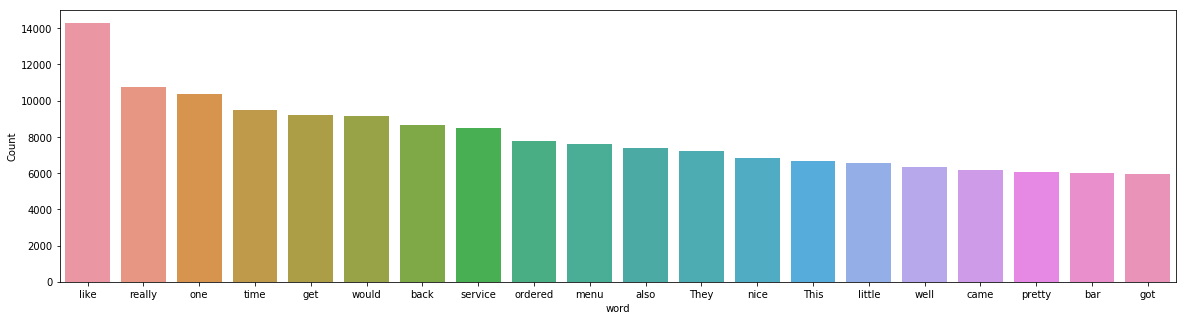

In [278]:
freq_words(reviews, 20)

In [280]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
reviews_2 = lemmatization(tokenized_reviews)

In [281]:
bigrams = phrases.Phrases(tokenized_reviews, min_count=3, threshold=10)

In [282]:
reviews_2 = [bigrams[line] for line in reviews_2]

In [283]:
trigrams = phrases.Phrases(reviews_2, min_count=3, threshold=10)

In [284]:
reviews_2 = [trigrams[line] for line in reviews_2]

In [523]:
import os
import codecs
intermediate_directory = os.path.join(path, 'interim')

In [528]:
bigram_model_filepath = os.path.join(intermediate_directory, 'bigram_model_all')
trigram_model_filepath = os.path.join(intermediate_directory, 'trigram_model_all')

In [530]:
print(bigram_model_filepath)
print(trigram_model_filepath)

/Users/dmitriykats/Documents/SpringBoard/Springboard/Capstone2/true_review/data/interim/bigram_model_all
/Users/dmitriykats/Documents/SpringBoard/Springboard/Capstone2/true_review/data/interim/trigram_model_all


In [531]:
bigrams.save(os.path.join(bigram_model_filepath, 'bigram_model'))
trigrams.save(os.path.join(trigram_model_filepath, 'trigram_model'))

In [ ]:
# load the finished model from disk
#bigram_model = Phrases.load(bigram_model_filepath)

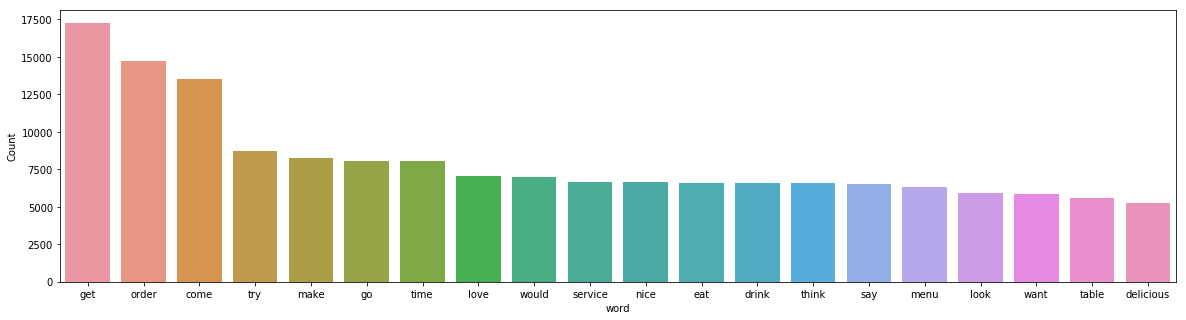

In [285]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))
    
df_scott['reviews'] = reviews_3
freq_words(df_scott['reviews'], 20)

In [287]:
print(df_scott.reviews.iloc[0])
print(f'Text length: {len(df_scott.reviews.iloc[0])}')


numerous amt time keep want friendly bartender exciting chef good_part comfort level night dollar specialty_cocktail espresso_martini wine day first_course app half app include lambchop tartar wonton_chip much great yearning last_night
Text length: 235


## LDA Model

In [247]:
dictionary = Dictionary(reviews_2)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [533]:
dictionary_filepath = os.path.join(intermediate_directory, 'dictionary_all')

In [534]:
dictionary_filepath

'/Users/dmitriykats/Documents/SpringBoard/Springboard/Capstone2/true_review/data/interim/dictionary_all'

In [536]:
dictionary.save(os.path.join(dictionary_filepath, 'dictionary'))
#doc_term_matrix.save(os.path.join(dictionary_filepath, 'doc_matrix'))

In [248]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.LdaMulticore

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, 
                id2word=dictionary, 
                num_topics=50, 
                random_state=42,
                chunksize=1000, 
                passes=100)

In [293]:
def explore_topic(topic_number, topn=20):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """   
    print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
    for term, frequency in lda_model.show_topic(topic_number, topn=20):
        print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [522]:
explore_topic(27)

term                 frequency

think                0.030
get                  0.028
bad                  0.022
price                0.021
go                   0.018
time                 0.017
say                  0.017
would                0.017
seem                 0.016
thing                0.016
well                 0.014
service              0.014
try                  0.014
eat                  0.013
come                 0.012
decent               0.011
feel                 0.010
place                0.010
cheap                0.010
average              0.009


In [513]:
topic_names = {0: u'service',
               1: u'sports bar',
               2: u'vegetarian, cafe',
               3: u'kid friendly',
               4: u'location',
               5: u'secret',
               6: u'sides, vietnamese',
               7: u'greek, hummus',
               8: u'food dishes',
               9: u'table, sit',
               10: u'golf',
               11: u'pizza, italian',
               12: u'dinner',
               13: u'big menue',
               14: u'sushi',
               15: u'bbq',
               16: u'dessert',
               17: u'french',
               18: u'healthy, salad',
               19: u'asian',
               20: u'quality, service',
               21: u'mall, food court',
               22: u'breakfast',
               23: u'burger & fries',
               24: u'wings, bbq',
               25: u'hotel',
               26: u'sushi',
               27: u'cheap, good, service',
               28: u'movie theater',
               29: u'comfort food',
               30: u'mexican',
               31: u'bars',
               32: u'italian',
               33: u'italian',
               34: u'coffee shop',
               35: u'lunch, sandwich',
               36: u'buffet',
               37: u'foreign, authentic',
               38: u'southern',
               39: u'service and seating',
               40: u'steak, dinner',
               41: u'happy hour, drinks',
               42: u'customer service',
               43: u'hard to find',
               44: u'tapas, appetizers',
               45: u'healthy',
               46: u'chinese',
               47: u'lunch',
               48: u'beer, wine, drinks',
               49: u'service'}

In [358]:
def get_sample_review(review_number):
    """
    retrieve a particular review index
    from the reviews file and return it
    """
    return df_scott.text.iloc[review_number]

In [498]:
def lda_description(review_text, min_topic_freq=0.05):
    """
    accept the original text of a review and (1) parse it with spaCy,
    (2) apply text pre-proccessing steps, (3) create a bag-of-words
    representation, (4) create an LDA representation, and
    (5) print a sorted list of the top topics in the LDA representation
    """
    # remove unwanted characters, numbers and symbols
    processed_review = review_text.replace("[^a-zA-Z#]", " ")
    # remove short words (length < 3)
    processed_review = ' '.join([w for w in processed_review.split() if len(w)>2])
    # make entire processed lowercase
    sample_review = processed_review.lower()
    
    # remove stopwords from the processed
    sample_review = [word for word in sample_review.split() if word not in stop_words]
    tokenized_sample = sample_review
    tags=['NOUN', 'ADJ', 'VERB']
    sample_lemma = [token.lemma_ for token in nlp(' '.join(tokenized_sample)) if token.pos_ in tags]
    
    bigram_reviews_2 = bigrams[sample_lemma]
    
    trigram_reviews_2 = trigrams[bigram_reviews_2]
    
    # create a bag-of-words representation
    review_bow = dictionary.doc2bow(trigram_reviews_2)
    
    # create an LDA representation
    review_lda = lda_model[review_bow]
    sorted_review_lda = sorted(review_lda, key=lambda tub: tub[1], reverse=True)
    print(sorted_review_lda)
    for topic_num, freq in sorted_review_lda:
        if freq < min_topic_freq:
            break
        print('{:25} {}'.format(topic_names[topic_num], format(freq, '.2f')))   

In [519]:
sample_review = get_sample_review(0)
print(sample_review)

I really like this place. I have been numerous amt of times and I keep wanting more. The friendly bartenders, the exciting chef  (Eddie). The best part of this place besides the good food and comfort level is their ALL Night Happy Hour. Yes All night $5 dollar specialty cocktails like an espresso martini or wines of the day. All first courses (apps) are half off too. The apps includes, lambchops ($19), Tuna tartar with wonton chips ($9) and so much more. Great s[ot and yearning for more since last night.


In [520]:
lda_description(sample_review)

[(12, 0.21445864), (41, 0.17708954), (27, 0.17509487), (47, 0.16283432), (36, 0.110533714), (45, 0.06124749), (40, 0.03885441), (6, 0.03437656)]
dinner                    0.21
happy hour, drinks        0.18
cheap, good, service      0.18
lunch                     0.16
buffet                    0.11
healthy                   0.06


In [249]:
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("lda_scott_model")
lda_model.save(temp_file)

# Load a potentially pretrained model from disk.
#lda_model = LdaModel.load(temp_file)

In [476]:
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
%matplotlib inline
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.196558  0.052568       1        1  3.909164
1     -0.131850  0.093025       2        1  0.733170
2     -0.209794  0.024165       3        1  0.367168
3     -0.100481  0.068054       4        1  0.847092
4      0.212048  0.062543       5        1  3.545687
5     -0.173758  0.050983       6        1  0.513989
6     -0.001922  0.010968       7        1  1.061407
7     -0.206874 -0.004774       8        1  0.358541
8      0.199900 -0.145111       9        1  7.429093
9      0.188776  0.179108      10        1  4.748863
10    -0.172165  0.043129      11        1  0.599565
11     0.032988 -0.152088      12        1  0.989533
12     0.134607  0.013190      13        1  2.837513
13    -0.133817  0.039951      14        1  0.641344
14     0.025641  0.123016      15        1  1.465272
15    -0.203460  0.038421      16        1  0.352981
16    -0.094041 -0.105800      17        1  1.093257
17    -0.156539 -0.011884      18        1  0.639876
18     0.072578 -0.162721      19        1  1.777839
19    -0.179498  0.014734      20        1  0.513210
20     0.283180  0.001383      21        1  6.369404
21    -0.209955  0.007152      22        1  0.307482
22     0.127319 -0.091938      23        1  2.049840
23     0.143618 -0.171623      24        1  2.671345
24    -0.154777 -0.066731      25        1  0.548842
25     0.102759  0.141587      26        1  2.485085
26    -0.059605 -0.067754      27        1  0.702526
27     0.232251  0.102502      28        1  5.153846
28    -0.030107  0.113179      29        1  0.938621
29    -0.199861  0.022445      30        1  0.433284
30     0.120669 -0.186251      31        1  2.096540
31     0.201497  0.166569      32        1  4.196297
32    -0.162093 -0.061912      33        1  0.472499
33    -0.182995  0.018963      34        1  0.503321
34     0.050633 -0.080501      35        1  1.228981
35    -0.080396 -0.110790      36        1  0.866021
36     0.026175  0.020443      37        1  1.421568
37    -0.171461 -0.015450      38        1  0.533639
38    -0.159870 -0.022023      39        1  0.561366
39     0.057691  0.172655      40        1  1.598807
40     0.215638 -0.111781      41        1  4.407473
41     0.132686  0.053778      42        1  2.458179
42     0.268043  0.111162      43        1  9.711244
43    -0.008269  0.133120      44        1  1.301478
44     0.001586 -0.211698      45        1  1.178654
45    -0.153226  0.002497      46        1  0.606646
46     0.162798 -0.204873      47        1  2.655699
47    -0.150911  0.055072      48        1  0.645057
48     0.072994 -0.000135      49        1  1.730901
49     0.225093  0.049478      50        1  5.740804, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
457   Default   5009.000000       salad   5009.000000  30.0000  30.0000
401   Default   3336.000000       lunch   3336.000000  29.0000  29.0000
655   Default   3580.000000       pizza   3580.000000  28.0000  28.0000
217   Default   3116.000000    sandwich   3116.000000  27.0000  27.0000
110   Default  14690.000000       order  14690.000000  26.0000  26.0000
127   Default   6525.000000       drink   6525.000000  25.0000  25.0000
37    Default   3195.000000      burger   3195.000000  24.0000  24.0000
846   Default   2391.000000        star   2391.000000  23.0000  23.0000
103   Default   3346.000000     chicken   3346.000000  22.0000  22.0000
209   Default   3498.000000      flavor   3498.000000  21.0000  21.0000
35    Default   2261.000000        beer   2261.000000  20.0000  20.0000
634   Default   3106.000000         fry   3106.000000  19.0000  19.0000
474   Default   2500.000000   breakfast   2500.000000  18.0000  18.0000
382   Default   2829.000000    location   2829.000000  17.0000  17.0000
1172  Default   4373.000000        dish   4373.00

In [268]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.023*"make" + 0.021*"service" + 0.020*"love" + 0.016*"wonderful" + 0.016*"amazing" + 0.015*"menu" + 0.014*"good" + 0.014*"experience" + 0.011*"delicious" + 0.010*"time"
Topic: 1 
Words: 0.068*"game" + 0.024*"sport_bar" + 0.018*"tv" + 0.016*"golf" + 0.016*"sport" + 0.016*"watch_game" + 0.015*"buddy" + 0.013*"play" + 0.011*"fun" + 0.011*"watch"
Topic: 2 
Words: 0.018*"vegetarian" + 0.015*"cupcake" + 0.013*"fianc" + 0.010*"information" + 0.010*"worth_trip" + 0.010*"lil" + 0.010*"favorite_restaurant" + 0.009*"machine" + 0.009*"breadstick" + 0.009*"free"
Topic: 3 
Words: 0.075*"kid" + 0.035*"mom" + 0.025*"family" + 0.025*"son" + 0.022*"daughter" + 0.016*"dad" + 0.013*"sister" + 0.012*"brother" + 0.011*"child" + 0.010*"croissant"
Topic: 4 
Words: 0.058*"location" + 0.020*"time" + 0.015*"area" + 0.014*"nice" + 0.014*"visit" + 0.013*"find" + 0.012*"spot" + 0.011*"favorite" + 0.011*"eat" + 0.011*"make"
Topic: 5 
Words: 0.012*"awesome" + 0.009*"secret" + 0.009*"regret" + 0.009*

# NLP

In [169]:
import os
import codecs
intermediate_directory = os.path.join(path, 'interim')

review_txt_filepath = os.path.join(intermediate_directory,
                                   'review_text_all.txt')

In [170]:
intermediate_directory

'/Users/dmitriykats/Documents/SpringBoard/Springboard/Capstone2/true_review/data/interim'

In [171]:
review_txt_filepath

'/Users/dmitriykats/Documents/SpringBoard/Springboard/Capstone2/true_review/data/interim/review_text_all.txt'

In [172]:
with codecs.open(review_txt_filepath, 'w', encoding='utf_8') as review_txt_file:
    df_scott.text.apply(lambda x: review_txt_file.write(x.replace('\n', '\\n') + '\n'))

In [174]:
with codecs.open(review_txt_filepath, encoding='utf_8') as f:
    sample_review = list(it.islice(f, 8, 9))[0]
    sample_review = sample_review.replace('\\n', '\n')
        
print(sample_review)

Love this place!  First time checking in and reviewing (because I'm trying to give back to the Yelp community more), but I've been here a bunch of times.

Start out with the Pig Wings - best BBQ ribs you'll ever have (well, pork ribs - my beef ribs are pretty hard to beat).  Never was much of a 'dipper', but the dipping sauce for the Pig Wings has got me dipping wings in blue cheese now.  

Then, go for the Shrimp Tamales.  Grilled shrimp on sweet corn tamales, smothered in a creamy sauce that's got a citrus-tart kick that contrasts perfectly with the tamale.  Amazing.

Then, finish off with the Key Lime Pie - best Key Lime Pie I've had anywhere!!



In [105]:
#import libraries
import spacy
import pandas as pd
import itertools as it

nlp = spacy.load('en')

Let's pass this review through Spacy

In [175]:
parsed_review = nlp(sample_review)

In [176]:
for num, sentence in enumerate(parsed_review.sents):
    print(f'Sentence {num + 1}: {sentence}')

Sentence 1: Love this place!  
Sentence 2: First time checking in and reviewing (because I'm trying to give back to the Yelp community more), but I've been here a bunch of times.


Sentence 3: Start out with the Pig Wings - best BBQ ribs you'll ever have (well, pork ribs - my beef ribs are pretty hard to beat).  
Sentence 4: Never was much of a 'dipper', but the dipping sauce for the Pig Wings has got me dipping wings in blue cheese now.  


Sentence 5: Then, go for the Shrimp Tamales.  
Sentence 6: Grilled shrimp on sweet corn tamales, smothered in a creamy sauce that's got a citrus-tart kick that contrasts perfectly with the tamale.  
Sentence 7: Amazing.


Sentence 8: Then, finish off with the Key Lime Pie - best Key Lime Pie I've had anywhere!!



Spacy has processed the review and identified many attributes of the text: sentences, entity detection, part of speech... etc.)

In [177]:
token_text = [token.orth_ for token in parsed_review]
token_pos = [token.pos_ for token in parsed_review]
d = {'token_text': token_text, 'part_of_speech': token_pos}
pd.DataFrame(data=d).head()

,token_text,part_of_speech
0,Love,VERB
1,this,DET
2,place,NOUN
3,!,PUNCT
4,,SPACE


In [178]:
token_lemma = [token.lemma_ for token in parsed_review]
token_shape = [token.shape_ for token in parsed_review]
d = {'token_text': token_text, 'token_lemma': token_lemma, 'token_shape': token_shape}
pd.DataFrame(data=d).head()

,token_text,token_lemma,token_shape
0,Love,love,Xxxx
1,this,this,xxxx
2,place,place,xxxx
3,!,!,!
4,,,


Looking at stopwords, punctuation, whitespace, number

In [223]:
token_attributes = [(token.orth_,
                     #token.prob,
                     token.is_stop,
                     token.is_punct,
                     token.is_space,
                     token.like_num,
                     token.is_oov)
                    for token in parsed_review]

df = pd.DataFrame(token_attributes,
                  columns=['text',
                           #'log_probability',
                           'stop?',
                           'punctuation?',
                           'whitespace?',
                           'number?',
                           'out of vocab.?'])

df.loc[:, 'stop?':'out of vocab.?'] = (df.loc[:, 'stop?':'out of vocab.?']
                                       .applymap(lambda x: u'Yes' if x else u''))
                                               
df.head(10)

,text,stop?,punctuation?,whitespace?,number?,out of vocab.?
0,Maybe,,,,,Yes
1,I,Yes,,,,Yes
2,am,Yes,,,,Yes
3,just,Yes,,,,Yes
4,getting,,,,,Yes
5,pickier,,,,,Yes
6,with,Yes,,,,Yes
7,each,Yes,,,,Yes
8,review,,,,,Yes
9,and,Yes,,,,Yes


## Phrase Modeling

In [180]:
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence

In [181]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space

def line_review(filename):
    """
    generator function to read in reviews from the file
    and un-escape the original line breaks in the text
    """
    
    with codecs.open(filename, encoding='utf_8') as f:
        for review in f:
            yield review.replace('\\n', '\n')
            
def lemmatized_sentence_corpus(filename):
    """
    generator function to use spaCy to parse reviews,
    lemmatize the text, and yield sentences
    """
    
    for parsed_review in nlp.pipe(line_review(filename),
                                  batch_size=10000, n_threads=4):
        
        for sent in parsed_review.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_space(token)])

In [182]:
unigram_sentences_filepath = os.path.join(intermediate_directory,
                                          'unigram_sentences_all.txt')

In [183]:
with codecs.open(unigram_sentences_filepath, 'w', encoding='utf_8') as f:
    for sentence in lemmatized_sentence_corpus(review_txt_filepath):
        f.write(sentence + '\n')

In [184]:
unigram_sentences = LineSentence(unigram_sentences_filepath)

In [185]:
for unigram_sentence in it.islice(unigram_sentences, 230, 240):
    print(' '.join(unigram_sentence))
    print('')

Kinda weird

-PRON- each order a traditional beer brat with root beer onion and an order of pretzel to share

the pretzel come out first

man those be some girthy pretzel

not sure if -PRON- be whole wheat but -PRON- be much hearty that what -PRON- get at Auntie Anne be that be for sure

-PRON- come with 3 type of mustard and a beer cheese sauce

the cheese sauce be just okay

-PRON- be kinda thin and a little bland

the waitress do ask -PRON- opinion though and -PRON- tell -PRON- what -PRON- think

-PRON- be nice to know -PRON- be open to improvement and want customer feedback



### Bigram Model

In [194]:
bigram_model_filepath = os.path.join(intermediate_directory, 'bigram_model_all')

In [195]:
bigram_model_filepath

'/Users/dmitriykats/Documents/SpringBoard/Springboard/Capstone2/true_review/data/interim/bigram_model_all'

In [189]:
bigram_model = Phrases(unigram_sentences)
#bigram_model.save(bigram_model_filepath)

In [ ]:
# load the finished model from disk
#bigram_model = Phrases.load(bigram_model_filepath)

In [190]:
bigram_sentences_filepath = os.path.join(intermediate_directory,
                                         'bigram_sentences_all.txt')

In [197]:
with codecs.open(bigram_sentences_filepath, 'w', encoding='utf_8') as f:
        
    for unigram_sentence in unigram_sentences:
            
        bigram_sentence = u' '.join(bigram_model[unigram_sentence])
            
        f.write(bigram_sentence + '\n')

In [198]:
bigram_sentences = LineSentence(bigram_sentences_filepath)

In [199]:
for bigram_sentence in it.islice(bigram_sentences, 230, 240):
    print(' '.join(bigram_sentence))
    print('')

Kinda weird

-PRON- each order a traditional beer brat with root_beer onion and an order of pretzel to share

the pretzel come out first

man those be some girthy pretzel

not sure if -PRON- be whole_wheat but -PRON- be much hearty that what -PRON- get at Auntie Anne be that be for sure

-PRON- come with 3 type of mustard and a beer cheese sauce

the cheese sauce be just okay

-PRON- be kinda thin and a little bland

the waitress do ask -PRON- opinion though and -PRON- tell -PRON- what -PRON- think

-PRON- be nice to know -PRON- be open to improvement and want customer feedback



### Trigram Model

In [200]:
trigram_model_filepath = os.path.join(intermediate_directory,
                                      'trigram_model_all')

In [201]:
trigram_model = Phrases(bigram_sentences)

In [203]:
trigram_sentences_filepath = os.path.join(intermediate_directory,
                                          'trigram_sentences_all.txt')

In [204]:
with codecs.open(trigram_sentences_filepath, 'w', encoding='utf_8') as f:
        
    for bigram_sentence in bigram_sentences:
            
        trigram_sentence = u' '.join(trigram_model[bigram_sentence])
            
        f.write(trigram_sentence + '\n')

In [205]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

In [206]:
for trigram_sentence in it.islice(trigram_sentences, 230, 240):
    print(' '.join(trigram_sentence))
    print('')


Kinda weird

-PRON- each order a traditional beer brat with root_beer_onion and an order of pretzel to share

the pretzel come out first

man those be some girthy pretzel

not sure if -PRON- be whole_wheat but -PRON- be much hearty that what -PRON- get at Auntie Anne be that be for sure

-PRON- come with 3 type of mustard and a beer cheese sauce

the cheese sauce be just okay

-PRON- be kinda thin and a little bland

the waitress do ask -PRON- opinion though and -PRON- tell -PRON- what -PRON- think

-PRON- be nice to know -PRON- be open to improvement and want customer feedback



Processing all the reviews

In [207]:
trigram_reviews_filepath = os.path.join(intermediate_directory,
                                        'trigram_transformed_reviews_all.txt')

In [210]:
from nltk.corpus import stopwords
my_stops = ['The', 'the', 'www', 'yelp', 'scottsdale', 'http', 'com', 'yelp', 'http_www', 'food', 'restaurant', 'place', 'good', 'great']
stop_words = stopwords.words('english')
for word in my_stops:
    stop_words.append(word)

In [212]:
with codecs.open(trigram_reviews_filepath, 'w', encoding='utf_8') as f:
        
    for parsed_review in nlp.pipe(line_review(review_txt_filepath),
                                      batch_size=10000, n_threads=4):
            
        # lemmatize the text, removing punctuation and whitespace
        unigram_review = [token.lemma_ for token in parsed_review
                              if not punct_space(token)]
            
        # apply the first-order and second-order phrase models
        bigram_review = bigram_model[unigram_review]
        trigram_review = trigram_model[bigram_review]
            
        # remove any remaining stopwords
        trigram_review = [term for term in trigram_review
                              if term not in stop_words]
            
        # write the transformed review as a line in the new file
        trigram_review = u' '.join(trigram_review)
        f.write(trigram_review + '\n')

In [214]:
print('Original:')
print('')
for review in it.islice(line_review(review_txt_filepath), 11, 12):
    print(review)

print('------------------------------')
print('Transformed:')
print('')
with codecs.open(trigram_reviews_filepath, encoding='utf_8') as f:
    for review in it.islice(f, 11, 12):
        print(review)

Original:

Scottsdale's Last Real Cowboy Saloon... I totally thought I'd reviewed Rusty Spur before as I've been more times than I can count.  I'll agree with most of the positive reviews already written about this place - it's laid back, un-pretentious, hole-in-the-wall, and fun!

I'm not a huge country music fan either, but when I come to Rusty Spur, I love it!  You can't help but smile and have a great time at this place!  If I don't start out here at Happy Hour, I end the night here whenever I'm out in Old Town.  

I'm left with a souvenir tank top that Jared bought me in his drunken state the other night when we were hanging at the Spur.  It says:
ALL JACKED UP
Big Time
Since 1951
RUSTY SPUR SALOON
Scottsdale, AZ

It's cute, but not quite as wonderful as entering into the doors of the Rusty Spur and leaving your troubles behind to enjoy the country music and cowboys that surround you!

------------------------------
Transformed:

Scottsdale 's last Real Cowboy saloon -PRON- totall

## LDA

In [216]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import warnings
import _pickle as pickle

In [217]:
trigram_dictionary_filepath = os.path.join(intermediate_directory,
                                           'trigram_dict_all.dict')

In [218]:
trigram_reviews = LineSentence(trigram_reviews_filepath)

# learn the dictionary by iterating over all of the reviews
trigram_dictionary = Dictionary(trigram_reviews)
    
# filter tokens that are very rare or too common from
# the dictionary (filter_extremes) and reassign integer ids (compactify)
trigram_dictionary.filter_extremes(no_below=10, no_above=0.4)
trigram_dictionary.compactify()

trigram_dictionary.save(trigram_dictionary_filepath)

### Loading the trigram dictionary from disk

In [ ]:
# load the finished dictionary from disk
#trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)

In [221]:
trigram_bow_filepath = os.path.join(intermediate_directory,
                                    'trigram_bow_corpus_all.mm')

In [222]:
def trigram_bow_generator(filepath):
    """
    generator function to read reviews from a file
    and yield a bag-of-words representation
    """
    
    for review in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(review)

In [224]:
# generate bag-of-words representations for
# all reviews and save them as a matrix
MmCorpus.serialize(trigram_bow_filepath,
                    trigram_bow_generator(trigram_reviews_filepath))
    
# load the finished bag-of-words corpus from disk
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)

In [226]:
lda_model_filepath = os.path.join(intermediate_directory, 'lda_model_all')

In [236]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
        
    # workers => sets the parallelism, and should be
    # set to your number of physical cores minus one
    lda = LdaMulticore(trigram_bow_corpus,
                           num_topics=50,
                           id2word=trigram_dictionary,
                           random_state=42,
                           chunksize=1000, 
                           passes=100)
#lda.save(lda_model_filepath)
    


In [ ]:
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("model")
lda.save(temp_file)

### Loading LDA model from disk

In [ ]:
# load the finished LDA model from disk
lda = LdaMulticore.load(lda_model_filepath)

In [230]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [237]:
explore_topic(topic_number=3)

term                 frequency

order                0.029
go                   0.026
one                  0.022
eat                  0.019
want                 0.016
love                 0.014
friend               0.014
like                 0.013
oh                   0.011
try                  0.011
say                  0.011
know                 0.009
also                 0.009
delicious            0.009
back                 0.008
day                  0.008
could                0.007
take                 0.007
leave                0.007
make                 0.007
thing                0.007
stuff                0.007
yummy                0.006
come                 0.006
think                0.006


In [238]:
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
%matplotlib inline
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus, trigram_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
23    -0.181621  0.126858       1        1  9.831486
10    -0.221211  0.113225       2        1  5.975516
35    -0.178051  0.062252       3        1  4.849523
1     -0.137139  0.168117       4        1  4.307855
36    -0.110573  0.178614       5        1  4.156357
11    -0.141189 -0.184176       6        1  3.931357
34    -0.127410 -0.102514       7        1  3.655622
4     -0.146143  0.113767       8        1  3.316786
2     -0.069937  0.093523       9        1  3.306954
8     -0.134718  0.124623      10        1  3.119583
24    -0.169756 -0.161253      11        1  3.065965
30    -0.078637  0.077400      12        1  2.469477
43    -0.119273 -0.189016      13        1  2.466115
46    -0.120719  0.111332      14        1  2.429182
3     -0.149635  0.043360      15        1  2.424095
18    -0.014233  0.006976      16        1  2.308347
38     0.001666  0.064389      17        1  2.303470
17    -0.114373 -0.167558      18        1  2.298343
21    -0.055642 -0.126316      19        1  2.073032
0     -0.140008 -0.099105      20        1  2.066045
26    -0.128312 -0.153323      21        1  1.940598
44    -0.116460  0.078788      22        1  1.877727
20    -0.147943 -0.097821      23        1  1.781473
27    -0.049746 -0.083490      24        1  1.755976
37    -0.037673  0.160646      25        1  1.719365
42     0.031612 -0.005650      26        1  1.688156
31     0.027941  0.083346      27        1  1.426194
6     -0.060715 -0.222686      28        1  1.365727
40     0.011491  0.168452      29        1  1.338380
9      0.054414 -0.165165      30        1  1.173960
47     0.011818 -0.139814      31        1  1.065799
14     0.049054  0.008413      32        1  0.900156
19     0.061687  0.010427      33        1  0.859457
29     0.171464  0.044603      34        1  0.805005
33     0.086884  0.026199      35        1  0.778053
49     0.058300 -0.016633      36        1  0.752760
5      0.153670  0.040116      37        1  0.741201
22     0.052219 -0.080485      38        1  0.717223
45     0.111378  0.094047      39        1  0.710988
15     0.117187  0.103101      40        1  0.708710
41     0.137925  0.001662      41        1  0.666015
28     0.197182 -0.046492      42        1  0.650648
7      0.161372 -0.022581      43        1  0.646927
16     0.242866 -0.033828      44        1  0.643552
13     0.198222 -0.005179      45        1  0.632439
12     0.145612  0.053143      46        1  0.618217
48     0.216535 -0.005060      47        1  0.542920
39     0.221750 -0.011300      48        1  0.396871
25     0.210609 -0.037597      49        1  0.385147
32     0.218259 -0.000338      50        1  0.355244, topic_info=      Category          Freq                       Term         Total  \
term                                                                    
196    Default   5383.000000                        bar   5383.000000   
569    Default   5471.000000                      salad   5471.000000   
782    Default   4102.000000                      pizza   4102.000000   
161    Default   6877.000000                      drink   6877.000000   
51     Default   3327.000000                     burger   3327.000000   
128    Default   4212.000000                    chicken   4212.000000   
459    Default   2858.000000                   location   2858.000000   
268    Default   3513.000000                   sandwich   3513.000000   
123    Default   2597.000000                          2   2597.000000   
136    Default  15053.000000                      order  15053.000000   
36     Default   2491.000000                       wine   2491.000000   
138    Default   8649.000000                    service   8649.000000   
49     Default   2639.000000                       beer   2639.000000   
587    Default   3798.000000                     always   3798.000000   
590    Default   2813.000000     